In [13]:
import pickle
import pandas as pd
import tensorflow as tf
from joblib import dump, load
from matplotlib import pyplot as plt

# Models for Planar Au Electrode trained on COMSOL data
names = ['ogHER', 'simple', 'ogHERandCER', 'Yogi']
name = names[3]
#scale = load(f'./Non_Yogi_Models/{name}_Model/scale_{name}.bin')
#i_model = tf.keras.models.load_model(f'./Non_Yogi_Models/{name}_Model/planar_i_{name}')
#fe_model = tf.keras.models.load_model(f'./Non_Yogi_Models/{name}_Model/planar_FE_{name}')

# Literature Gold Data -- Isolating Jingyu Data
f = pd.read_csv('gold_lit_data_Dec3.csv')
f = f.loc[f['source'] =="Jingyu"].copy()
f

,E,FE,i,hco3,source
0,-0.53,0.7913,0.413300,0.1,Jingyu
1,-0.62,0.8807,0.665581,0.1,Jingyu
2,-0.71,0.9438,1.028164,0.1,Jingyu
3,-0.82,0.8820,1.380211,0.1,Jingyu
4,-0.90,0.7761,1.522053,0.1,Jingyu
5,-1.01,0.5977,1.760422,0.1,Jingyu


In [14]:
# Load BO variables from fitting
BO_res = pickle.load(open(f'./BO_Results/{name}_Best.pkl', 'rb'))
BO_res = BO_res[0]
BO_res

{'Ex1': -3.22515,
 'Ex2': -6.71729,
 'Ex3': -0.23771,
 'dif': 372.0,
 'o1': 0.13089,
 'o2': 0.08438,
 'o3': 0.86534,
 'o4': 0.84369,
 'o5': 0.71676,
 'o6': 0.79954}

In [5]:
# Run predictions on using loaded variables
ans_fe = []
ans_i = []
for i in range(len(f)):
    order = 'o' + str(i+1)
    #vals = [[f.loc[i,'E'], BO_res.get(order), BO_res.get('Ex1'), BO_res.get('Ex2'), BO_res.get('Ex3'), BO_res.get('dif')]]
    vals = [[f.loc[i,'E'] , BO_res.get('i1c'), BO_res.get('i1h'), BO_res.get('dif'), 0.1, BO_res.get(order)]]
    print(vals)
    vals = scale.transform(vals)
    ans_fe.append(fe_model.predict(vals)[0][0])
    ans_i.append(i_model.predict(vals)[0][0]) 
print(ans_fe)
print(ans_i)
t = pd.DataFrame()
t['E'] = f.loc[:,'E']
t['FE'] = ans_fe
t['i'] = ans_i
t['hco3'] = 0.1
t['source'] = name
t = pd.concat([f, t])
t.to_csv(f'FittingResults_{name}.csv', index=False)

[[-0.53, -3.43851, -5.86887, 37.0, 0.1, 0.37683]]
[[-0.62, -3.43851, -5.86887, 37.0, 0.1, 0.3197]]
[[-0.71, -3.43851, -5.86887, 37.0, 0.1, 0.59397]]
[[-0.82, -3.43851, -5.86887, 37.0, 0.1, 0.18515]]
[[-0.9, -3.43851, -5.86887, 37.0, 0.1, 0.52387]]
[[-1.01, -3.43851, -5.86887, 37.0, 0.1, 0.43372]]
[0.98403484, 0.96924436, 0.9562306, 0.90725625, 0.8137328, 0.4418134]
[0.093917534, 0.8459256, 1.5775906, 2.284172, 2.6158977, 3.0244095]


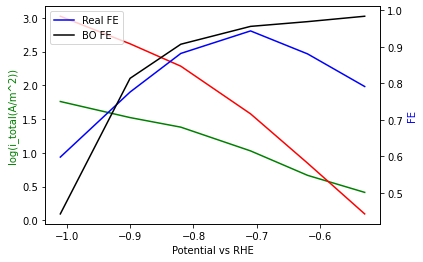

In [7]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(f.loc[:, 'E'], f.loc[:, 'i'], 'g-', label='Real Cur')
ax2.plot(f.loc[:, 'E'], f.loc[:, 'FE'], 'b-', label='Real FE')
ax1.plot(f.loc[:, 'E'], ans_i, 'r-', label='BO Cur')
ax2.plot(f.loc[:, 'E'], ans_fe, 'k-', label='BO FE')

ax1.set_xlabel('Potential vs RHE')
ax1.set_ylabel('log(i_total(A/m^2))', color='g')
ax2.set_ylabel('FE', color='b')

plt.legend()
plt.show()

In [ ]:
import os
from sklearn.preprocessing import StandardScaler as SScaler
import warnings
import numpy as np
warnings.filterwarnings('ignore', category=DeprecationWarning)

path = './Non_Yogi_Models'
models = os.listdir(path)
print(models)
for mod in models:
    if (not mod.startswith('.')):
        data = pd.read_csv(f'{path}/{mod}/{mod[:-6]}.csv')
        print(mod)
        print(data.head())
        scaler = SScaler()
        scaler.fit_transform(data)
        i_model = tf.keras.models.load_model(f'{path}/{mod}/planar_i_{mod[:-6]}')
        ar = np.array(list(data.iloc[0, 2:])) #CHANGE
        ar = ar.reshape(1,-1)
        print(i_model.predict(ar))

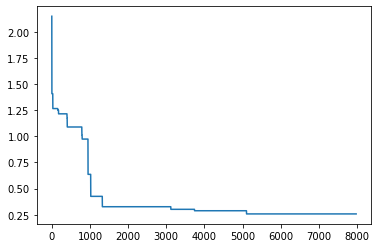

In [20]:
import pandas as pd, pickle
from matplotlib import pyplot as plt

def fix(losses):
    cur_min = float('inf')
    fixed = []
    for loss in losses:
        to_append = cur_min
        if loss < cur_min:
            to_append = loss
            cur_min = loss
        else:
            fixed.append(cur_min)
    return fixed

trials = pickle.load(open('./BO_Results/Yogi.hyperopt', 'rb'))
#print(f'{[t for t in trials][:1]}\n')
losses = []
for i, trial in enumerate(trials):
    losses.append(trial['result']['loss'])
losses_min = fix(losses)
plt.plot(range(len(losses_min)), losses_min)
df = pd.DataFrame(enumerate(losses_min), columns=['Trial','Loss'])
df.to_csv('BO_of_COMSOL.csv', index=False)